## DSCI 100 Group Project 

By Tony Fu, Hao Jiang, and Aimee Garcia Castro

## Introduction: 

There are many elements that play a role in how well a student will perform on a test. The objective for this group project is predicting the knowledge level of an individual based on such elements. The knowledge levels include: `high`, `middle`, `low` and `very_low` We will be looking at the "User Knowledge" dataset obtained from the UCI Machine Learning Repository. The data in this dataset looks at `STG` (the degree of study time for goal object materials), `SCG` (the degree of repetition number of user for goal object materials), `STR` (the degree of study time of user for related objects with goal object), `LPR` (the exam performance of user for related object with goal object), and `PEG` (the exam performance of user for goal objects). As well, it relates `PEG` to `UNS` (the knowledge level of the user). This data will be used as predictors for `UNS`
 
Our predictive question that we will try to answer is: “Can we predict the `UNS` of an individual based on factors such as `STG`, `SCG`, and `STR`?”
 


## Methods: 

We begin by loading the libraries required to perform exploratory analysis. 

In [29]:
library(tidyverse)
library(ggplot2)
library(tidymodels)
library(repr)
library(GGally)
library(readxl)
options(repr.matrix.max.rows = 6)

Now, we need to transfer the data from the website to R, since the data is located on the website. As the data is available as an Excel spreadsheet, we are going to need to download it as a file with `download.file`. We have stored the file described as an url from the Internet as an object called `url` and used this in the `download.file` function.

After we have downloaded the data as a file on R, we are going to use the `read_excel` function to transfer the data from the spreadsheet. We will be using the `sheet` function to specify which sheet of the Excel file contains the data we are going to use. This will be `sheet = 2` as the second sheet is listed as **training data**, which will be crucial once we create our classifier. 

We notice that the last 3 columns are irrelevant to the data, so we will be removing those by selecting the wanted data with the `select` function.

Furthermore, although not required, we chose to lowercase all the `UNS` labels to keep the labeling consistent with the `mutate` function, along with the `recode` function.

In [30]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")

user_knowledge <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 2) %>%
    select(STG:UNS) %>%
    mutate(UNS = recode(UNS, High = 'high', Middle = 'middle', Low = 'low'))

user_knowledge

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,high
0.50,0.75,0.81,0.61,0.26,middle
0.66,0.90,0.76,0.87,0.74,high


*Table 1*: Tidied "User Knowledge" dataset obtained from UCI Machine Learning Repository

## Searching for NAs:


We will now be looking for NA values in our data frame, and handle them appropriately as they represent a missing or incomplete value in our data. 

In [31]:
sum(is.na(user_knowledge))

[1] 0

Thankfully there are no NAs in our data frame, so no further adjustments must be made to our current data frame.

## Defining Variables:

We have already mentioned what each of the variables acronym means in the introduction. However, to reiterate, `STG` represents the study time for main topics, `SCG` represents the reptition in studying, `STR` represents study time for related topics, `LPR` represents exam performance of related topics, `PEG` represents exam performance of main topics, and `UNS` represents the knowledge level. All variables from `STG` to `PEG` have a range from 0 to 1. `UNS` contain the labels `very_low`, `low`, `middle`, and `high`, where `very_low` corresponds to a low `PEG` whereas `high` corresponds to a high `PEG`.

## Determining Predictors:

To begin, we have decided to remove `LPR` since a high `LPR` would result from a high `STR`. This means that if we included both as predictors, we would essentially be using the same predictor twice, leading to these `STR` having a larger influence than wanted. Furthermore, we have also decided to remove `PEG` since `UNS` is based on `PEG`, meaning `PEG` will have a larger influence than the other possible predictors.

In [32]:
user_knowledge <- user_knowledge %>%
    select(-LPR, -PEG)

user_knowledge

STG,SCG,STR,UNS
<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,very_low
0.08,0.08,0.10,high
0.06,0.06,0.05,low
⋮,⋮,⋮,⋮
0.54,0.82,0.71,high
0.50,0.75,0.81,middle
0.66,0.90,0.76,high


*Table 2*: Potential predictors that may be used for analysis

Now, we are left with four variables: `STG`, `SCG`, `STR`, and `UNS`. Since the categorical class we are trying to predict `UNS`, we must turn it into a factor. This is done by using the `mutate` and `as_factor` functions.

In [33]:
user_knowledge <- user_knowledge %>%
    mutate(UNS = as.factor(UNS))

user_knowledge

STG,SCG,STR,UNS
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,very_low
0.08,0.08,0.10,high
0.06,0.06,0.05,low
⋮,⋮,⋮,⋮
0.54,0.82,0.71,high
0.50,0.75,0.81,middle
0.66,0.90,0.76,high


*Table 3*: Potential predictors with `UNS` changed to class "factor"

Currently, we need to see which predictors we should use and which ones should be removed. We will do this through a method called forward selection, where we are building a model by adding one predictor at a time. This model will select the most accurate combinations given the predictors STG, SCG, and STR. We have also used the `set.seed` function to make sure our findings for accuracy are reproducible. 

*Note: The following code was taken from Chapter 6.8 of the textbook.*

In [34]:
set.seed(1)

names <- colnames(user_knowledge %>% select(-UNS)) 
example_formula <- paste("UNS", "~", paste(names, collapse="+"))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

user_knowledge_vfold <- vfold_cv(user_knowledge, v = 5, strata = UNS)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        user_knowledge_recipe <- recipe(as.formula(model_string), 
                                data = user_knowledge) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
        acc <- workflow() %>%
          add_recipe(user_knowledge_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = user_knowledge_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ STG,0.5001508
2,UNS ~ STG+STR,0.4033183
3,UNS ~ STG+STR+SCG,0.3917044


*Table 4*: Accuracies of different number of predictors used in the model

As we can see in the table, the most accurate predictor is `STG`. The second most would be `STR`, since the model selected the combination of `STG` and `STR` as the most accurate when using two predictors. Finally, `SCG` would be the least accurate predictor out of the three. We can also see that there is a constant decrease when we add predictors. We tried removing `STG` from the data set to have the model measure the accuracy of the combination of predictors `STR` and `SCG`. We further tried removing `STR` from the data set to have the model measure the accuracy of the combination of predictors `STG` and `SCG`. We found that the original combination of `STG` and `STR` resulted in the highest accuracy of the combination of two predictors, which is why we are going to be using these two in our analysis as we require two predictors to create a plot for predictions. Thus, we can remove `SCG` from our data frame.

In [35]:
user_knowledge <- user_knowledge %>%
    select(-SCG)

user_knowledge

STG,STR,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,very_low
0.08,0.10,high
0.06,0.05,low
⋮,⋮,⋮
0.54,0.71,high
0.50,0.81,middle
0.66,0.76,high


*Table 5*: Predictors that will be used for analysis

## Exploratory Analysis:

To start, we will perform some exploratory analysis on our predictors `STG` and `STR` and see their relationship with our categorial variable of interest `UNS`. Since `UNS` has different levels, we will create boxplots showing the relationship between `STG` and each level of `UNS`. We will be reordering the boxplots in terms of ascending order of means.

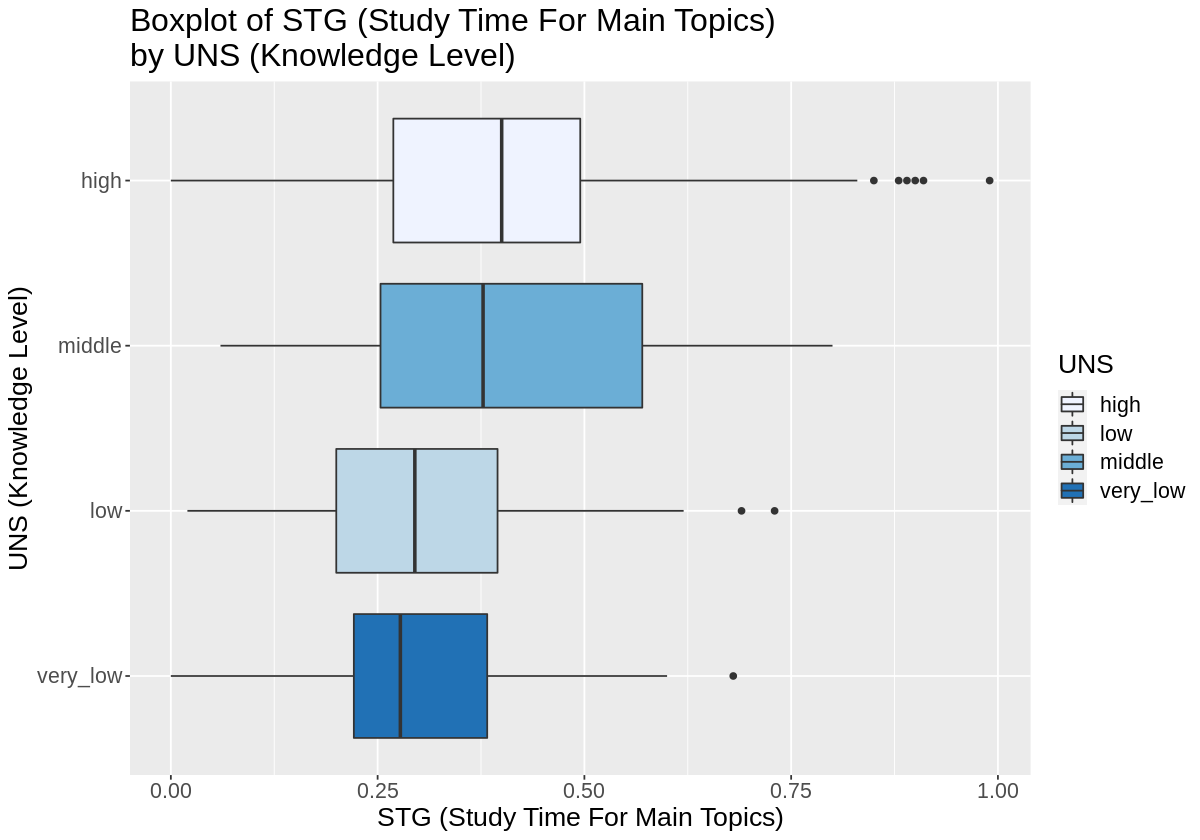

In [36]:
user_knowledge_plot <- ggplot(user_knowledge, aes(x = STG, y = reorder(UNS, +STG), fill = UNS)) +
    geom_boxplot() +
    labs(x = "STG (Study Time For Main Topics)", y = "UNS (Knowledge Level)") +
    ggtitle("Boxplot of STG (Study Time For Main Topics) \nby UNS (Knowledge Level)") + 
    scale_fill_brewer(palette="Blues") +
    theme(text = element_text(size = 16)) 

user_knowledge_plot

*Figure 1*: Boxplot of `STG` per `UNS`

Looking at Figure 1, we can see that the mean for `very_low` has the lowest `STG` while the mean for `high` has the highest `STG`. We can conclude that as `STG` increases, so does the `UNS` as seen with the means of each boxplot. This indicates that there is a positive relationship between `STG` and the different levels of `UNS` based on the means. Hence, `STG` does affect the levels of `UNS` and this will be discussed in our data analysis section.

We can make similar boxplots showing the relationship between `STR` and each level of `UNS`.

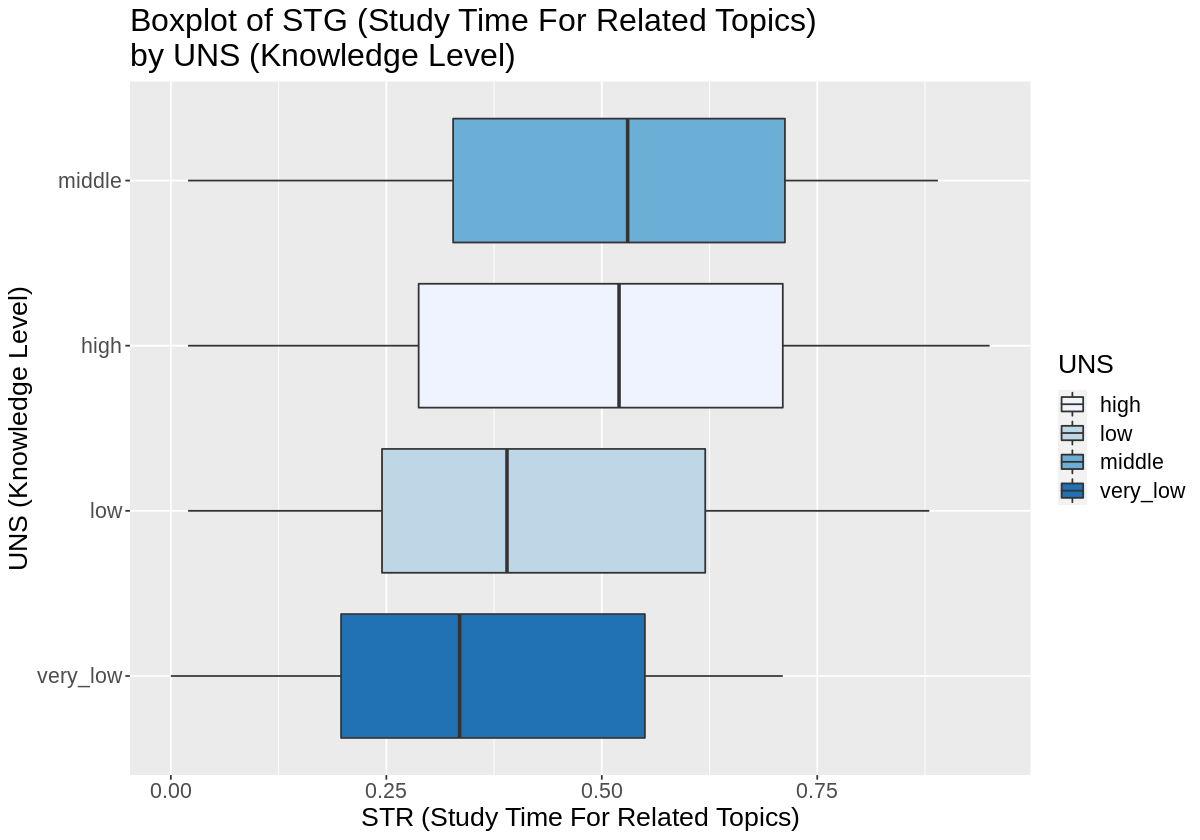

In [37]:
user_knowledge_plot_2 <- ggplot(user_knowledge, aes(x = STR, y = reorder(UNS, +STR), fill = UNS)) +
    geom_boxplot() +
    labs(x = "STR (Study Time For Related Topics)", y = "UNS (Knowledge Level)") +
    ggtitle("Boxplot of STG (Study Time For Related Topics) \nby UNS (Knowledge Level)") + 
    scale_fill_brewer(palette="Blues") +
    theme(text = element_text(size = 16)) 

user_knowledge_plot_2

*Figure 2*: Boxplot of `STR` per `UNS`

Looking at Figure 2, we can see that similarly, `very_low` and `low` have the lowest and second lowest means respectively. However, `middle` has a STR mean that is slightly larger than the STR mean of `high`. Therefore, we can say there is a positive relationship between `STR` and the different levels of `UNS` based on the means till it gets to `middle` and `high` where they have relatively the same mean. Thus, we can say `STR` does impact `UNS` from `very_low` to `middle` and `high`, but it does not have a great impact between `middle` and `high`. This will be talked about in the data analysis section.

## Summarizing the Data Set

Now, we will summarize the data set to obtain statistics which will be used for the data analysis section.  

First, we start by calculating the mean, median, and standard deviation of both `STG` and `STR` in the data set.

In [38]:
stg_stats <- user_knowledge %>%
    summarize(mean_stg = mean(STG),
              med_stg = median(STG), 
              sd_stg = sd(STG))

stg_stats

mean_stg,med_stg,sd_stg
<dbl>,<dbl>,<dbl>
0.3711473,0.327,0.2102712


*Table 7*: Mean, median, and standard deviation of `STG`

In [39]:
str_stats <- user_knowledge %>%
    summarize(mean_stg = mean(STG),
              med_stg = median(STG), 
              sd_stg = sd(STG))

str_stats

mean_stg,med_stg,sd_stg
<dbl>,<dbl>,<dbl>
0.3711473,0.327,0.2102712


*Table 8*: Mean, median, and standard deviation of `STR`

## Building the Classifier

Before we start building our model, we found the number and percentage of the levels of `UNS` in our data set. To do that, we use the `group_by`, `summarize` and `n` functions. The `n` function inside `summarize`, when combined with `group_by`, counts the number of observations. Then, using `mutate`, we calculate the percentage in each group by dividing n by the total number of observations.

In [40]:
UNS_proportions <- user_knowledge %>%
                      group_by(UNS) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(user_knowledge))
UNS_proportions

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n,percent
<fct>,<int>,<dbl>
high,63,24.418605
low,83,32.170543
middle,88,34.108527
very_low,24,9.302326


*Table 9*: Proportions of each UNS level 


We have 63 (24%) high levels, 88 (34%) middle levels, 83 (32%) low levels and 24 (9%) very low levels of UNS in our data set.

Next, we will perform a 10-fold cross-validation so that we can have 10 different options for the validation set. In order to do so, we use the `vfold_cv` function along with the data set, the number of folds (v), and the strata arguments. The strata argument contains our categorical variable `UNS`.  

In [41]:
user_knowledge_vfold <- vfold_cv(user_knowledge, v = 10, strata = UNS)
print(user_knowledge_vfold)

#  10-fold cross-validation using stratification 
# A tibble: 10 x 2
   splits           id    
   <list>           <chr> 
 1 <split [231/27]> Fold01
 2 <split [231/27]> Fold02
 3 <split [231/27]> Fold03
 4 <split [231/27]> Fold04
 5 <split [231/27]> Fold05
 6 <split [232/26]> Fold06
 7 <split [233/25]> Fold07
 8 <split [234/24]> Fold08
 9 <split [234/24]> Fold09
10 <split [234/24]> Fold10


Below we make the k_vals data frame with the neighbors variable containing values from 1 to 100 (stepping by 5) using the seq function. After that, we create and tune our model, and specify the recipe with our scaled and centered predictors. Then we make our workflow containing the recipe and the model and we pass the k_vals data frame to the grid argument of tune_grid function. Finally, we use the collect_metrics function to add the mean and standard error of the classifier’s validation accuracy and we filter from the .metrics column to see the accuracy.

In [42]:
set.seed(1)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

user_knowledge_recipe <- recipe(UNS ~ STG + STR, data = user_knowledge) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())

# fit the knn model 
user_knowledge_results <- workflow() %>%
                      add_recipe(user_knowledge_recipe) %>%
                      add_model(knn_tune) %>%
                      tune_grid(resamples = user_knowledge_vfold, grid = k_vals) %>%
                      collect_metrics()%>% 
                      filter(.metric == "accuracy") 
user_knowledge_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3407123,10,0.02969972,Model01
6,accuracy,multiclass,0.3879558,10,0.03133319,Model02
11,accuracy,multiclass,0.3899744,10,0.03087201,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,multiclass,0.3883376,10,0.01734960,Model18
91,accuracy,multiclass,0.3715413,10,0.02408465,Model19
96,accuracy,multiclass,0.3678376,10,0.02327837,Model20


*Table 10*: Results from 10-fold cross validation

In order to choose the best number of neighbors we create a line graph using the user_knowledge_results dataset with neighbors on the x-axis and the mean on the y-axis.

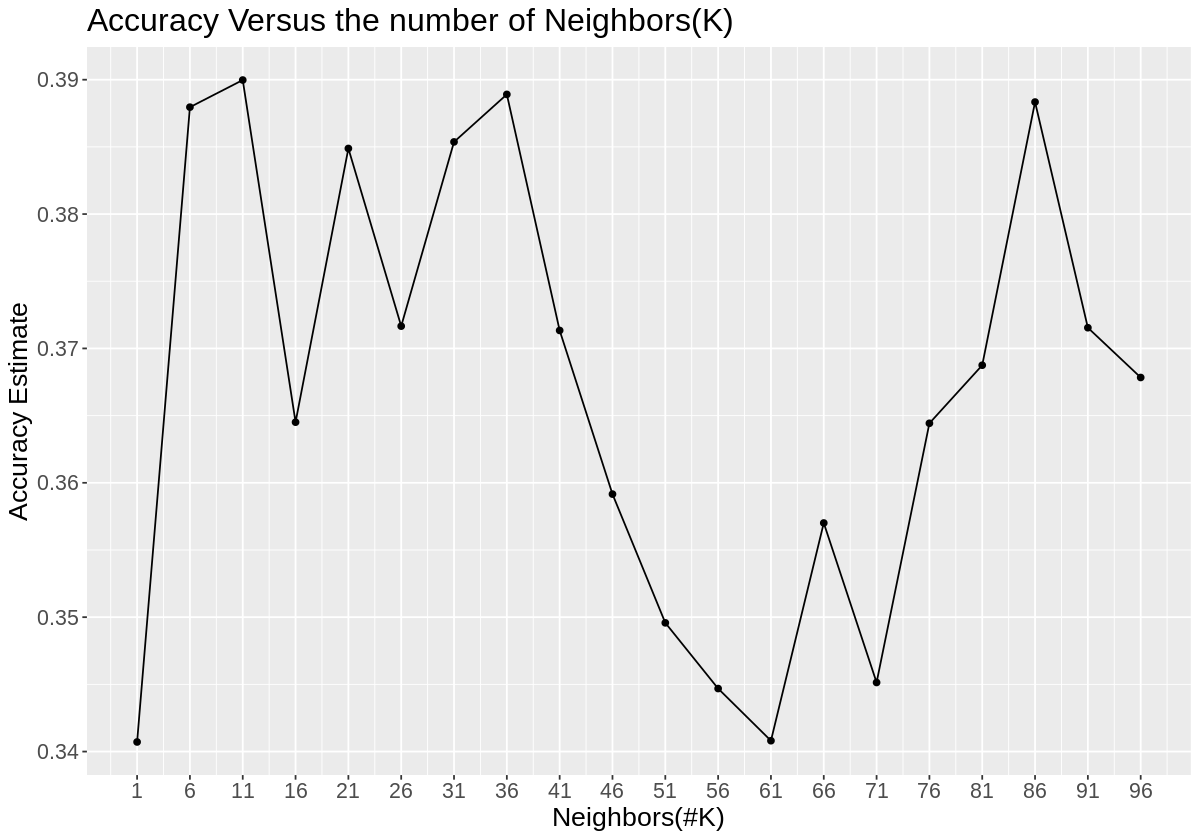

In [43]:
options(repr.plot.width = 10, repr.plot.height = 7)
accuracy_versus_k <- ggplot(user_knowledge_results, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors(#K)", y = "Accuracy Estimate")+
      ggtitle("Accuracy Versus the number of Neighbors(K)")+
      theme(text = element_text(size = 16))+
      scale_x_continuous(breaks = seq(1, 96, by = 5))
accuracy_versus_k

*Figure 3*: Plot of accuracy estimate vs neighbors

We take the K with the highest peak to use in the classifier. In this case, any value between 6 to 11 would be acceptable as they are the highest in the graph. We have decided to use K = 6. We will remake our model using this new K value.

In [44]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
          set_engine("kknn") %>%
          set_mode("classification")
knn_spec_2

user_knowledge_fit <- workflow() %>%
                      add_recipe(user_knowledge_recipe) %>%
                      add_model(knn_spec_2) %>%
                      fit(data = user_knowledge)
user_knowledge_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 6
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~6, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5581395
Best kernel: rectangular
Best k: 6

To evaluate the estimated accuracy of our classifier on the test set, we use the `predict` and `bind_cols` functions. We can compare the .pred_class column (which contains the predictions from our classifier) with the `UNS` column (which contains the true values).

In [45]:
user_knowledge_test <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 3) %>%
    select(STG, STR, UNS) %>%
    mutate(UNS = gsub(" ", "", UNS)) %>%
    mutate(UNS = recode(UNS, High = "high", Middle = "middle", Low = "low", VeryLow = "very_low")) %>%
    mutate(UNS = as.factor(UNS))

user_knowledge_test_predictions <- predict(user_knowledge_fit , user_knowledge_test) %>%
                                   bind_cols(user_knowledge_test)

user_knowledge_test_predictions



New names:
* `` -> ...7
* `` -> ...8



.pred_class,STG,STR,UNS
<fct>,<dbl>,<dbl>,<fct>
low,0.00,0.50,very_low
low,0.05,0.55,low
low,0.08,0.63,high
⋮,⋮,⋮,⋮
middle,0.56,0.77,low
middle,0.66,0.81,middle
middle,0.68,0.79,middle


*Table 11*: Testing data with our classifier's prediction added

Finally, to get statistics about the quality of our model, we use the metrics function and we filter by .metrics to see the accuracy.

In [46]:
user_knowledge_prediction_accuracy <- user_knowledge_test_predictions %>%
                metrics(truth = UNS, estimate = .pred_class) %>%
                filter(.metric == "accuracy")

user_knowledge_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3931034


*Table 12*: The metrics of classifier's predictions on the testing data


Looking at the value of the .estimate variable shows that the estimated accuracy of the classifier on the test data is 39%.

Also, by using the conf_mat function we looked at the confusion matrix in order to see the table of predicted labels and correct labels.

In [47]:
user_knowledge_mat <- user_knowledge_test_predictions %>% 
      conf_mat(truth = UNS, estimate = .pred_class)

user_knowledge_mat

          Truth
Prediction high low middle very_low
  high       11   4      6        5
  low        10  27     10       16
  middle     18  15     18        4
  very_low    0   0      0        1

*Table 13*: Confusion matrix that shows correct and incorrect predictions

Our classifier predicted `high` correctly 11 times and incorrectly 28 times. It predicted `middle` correctly 18 times and incorrectly 16 times. It predicted `low` correctly 27 times and incorrectly 19 times. It also predicted `very_low` correctly 1 time and incorrectly 25 times.